In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import dataProcess

from datetime import datetime
import matplotlib.pyplot as plt
import optuna

In [3]:
def nan_to_above(data):
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      for k in range(data.shape[2]):
        if torch.isnan(data[i, j, k]):
          if j == 0:
            data[i, j, k] = 0
          else:
            data[i, j, k] = data[i, j-1, k]

In [4]:
# data preprocessing

# 2014-04-16
start = datetime(2014, 4, 16).date()
# 2024-04-11
end = datetime(2024, 4, 11).date()
hourly_path ='weatherstats_toronto_hourly.csv'
daily_path ='weatherstats_toronto_daily.csv'

# data
data_tensor_preprocess = dataProcess.dataToTensorHourly(hourly_path, separateByDay=False, missingThreshold=0.1, columnToDelete=['wind_dir', 'unixtime'], start=start, end=end)
data_tensor_preprocess_r = torch.flip(data_tensor_preprocess[0], dims=[0])


In [5]:
data2 = data_tensor_preprocess_r[:-7].reshape(-1, 24, 13)
data2 = data_tensor_preprocess_r[:-7]
data3 = data2.reshape(-1, 24, 13)
nan_to_above(data3)

In [6]:
data = data3[:, :, 1:]
print(data.shape)
print(data[0][0])
print(data[-1][-1])

torch.Size([3648, 24, 12])
tensor([ 1.0011e+02,  1.0228e+02,  3.0000e+01,  2.7000e+01,  5.7000e+01,
        -1.2400e+01, -5.1000e+00,  2.4100e+04,  0.0000e+00, -4.9000e+00,
        -5.1000e+00,  1.0500e+02], dtype=torch.float64)
tensor([  97.8700,   99.9300,   26.0000,    6.0000,  100.0000,   12.6000,
          12.6000, 4800.0000,    8.0000,   12.6000,   11.3000,  101.0000],
       dtype=torch.float64)


In [7]:
# targets
targets_1 = dataProcess.dailyTargets(daily_path, start=datetime(2014, 4, 17).date())
targets = torch.flip(targets_1, dims=[0])
print(targets.shape)
print(targets[0])
print(targets[-1])

torch.Size([3648])
tensor(3.7500, dtype=torch.float64)
tensor(11.1500, dtype=torch.float64)


In [14]:
def process_data_for_rnn_gru(train_fraction, valid_fraction, data, targets, batch_size):

  train_dataset = TensorDataset(data, targets)
  total_size = len(data)
  train_split_point = int(total_size * train_fraction)
  valid_split_point = train_split_point + int(total_size * valid_fraction)

  train_dataset = TensorDataset(data[:train_split_point], targets[:train_split_point])
  val_dataset = TensorDataset(data[train_split_point:valid_split_point],
                              targets[train_split_point:valid_split_point])
  test_dataset = TensorDataset(data[valid_split_point:], targets[valid_split_point:])

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = process_data_for_rnn_gru(0.6, 0.2, data, targets, 2048)

In [17]:
class WeatherPredictorGRU(nn.Module):
  def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, num_layers=1, dropout_rate=0.0):
    super(WeatherPredictorGRU, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size1, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
    self.linear1 = nn.Linear(hidden_size1, hidden_size2)
    self.linear2 = nn.Linear(hidden_size2, hidden_size3)
    self.output_linear = nn.Linear(hidden_size3, output_size)
    self.relu = nn.ReLU()

  def forward(self, x):
    out, _ = self.gru(x)
    x = out[:, -1, :]
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    prediction = self.output_linear(x)
    return prediction


In [21]:
def train_model(trial, model, num_epochs, train_loader, val_loader, device):
  criterion = nn.MSELoss()
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

  avg_val_loss = total_val_loss / len(val_loader)
  return avg_val_loss

def objective(trial):
  input_size = 12
  hidden_size1 = trial.suggest_categorical('hidden_size1', [16, 32, 64, 128, 256])
  hidden_size2 = trial.suggest_categorical('hidden_size2', [16, 32, 64, 128, 256])
  hidden_size3 = trial.suggest_categorical('hidden_size3', [16, 32, 64, 128, 256])
  output_size = 1
  num_layers = trial.suggest_int('num_layers', 1, 3)
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = WeatherPredictorGRU(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, num_layers, dropout_rate)
  model.to(device)

  num_epochs = 40
  return train_model(trial, model, num_epochs, train_loader, val_loader, device)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
  print(f"    {key}: {value}")

[I 2024-04-19 00:00:05,161] A new study created in memory with name: no-name-4289f5ce-025b-4797-a6d1-91a3a80e17ad
<ipython-input-21-1580a971041d>:39: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
<ipython-input-21-1580a971041d>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-04-19 00:00:08,116] Trial 0 finished with value: 137.10189819335938 and parameters: {'hidden_size1': 256, 'hidden_size2': 128, 'hidden_size3': 128, 'num_layers': 2, 'dropout_rate': 0.024882251537076405, 'lr': 0.0005354123776259245}. Best is trial 0 with value: 137.10189819335938.
[I 2024-

Best trial:
  Value: 133.32041931152344
  Params: 
    hidden_size1: 32
    hidden_size2: 256
    hidden_size3: 16
    num_layers: 2
    dropout_rate: 0.2566471654178661
    lr: 0.0005485425809633671


Epoch [1/50], Training Loss: 117.4823, Validation Loss: 206.0057
Epoch [2/50], Training Loss: 117.0237, Validation Loss: 205.0834
Epoch [3/50], Training Loss: 116.5624, Validation Loss: 204.1915
Epoch [4/50], Training Loss: 116.1147, Validation Loss: 203.2886
Epoch [5/50], Training Loss: 115.6692, Validation Loss: 202.3172
Epoch [6/50], Training Loss: 115.1857, Validation Loss: 201.2689
Epoch [7/50], Training Loss: 114.6693, Validation Loss: 200.1398
Epoch [8/50], Training Loss: 114.1060, Validation Loss: 198.9125
Epoch [9/50], Training Loss: 113.4994, Validation Loss: 197.5469
Epoch [10/50], Training Loss: 112.8481, Validation Loss: 195.9826
Epoch [11/50], Training Loss: 112.1123, Validation Loss: 194.2440
Epoch [12/50], Training Loss: 111.2954, Validation Loss: 192.3336
Epoch [13/50], Training Loss: 110.4070, Validation Loss: 190.2605
Epoch [14/50], Training Loss: 109.4893, Validation Loss: 188.0145
Epoch [15/50], Training Loss: 108.4419, Validation Loss: 185.5723
Epoch [16/50], Trai

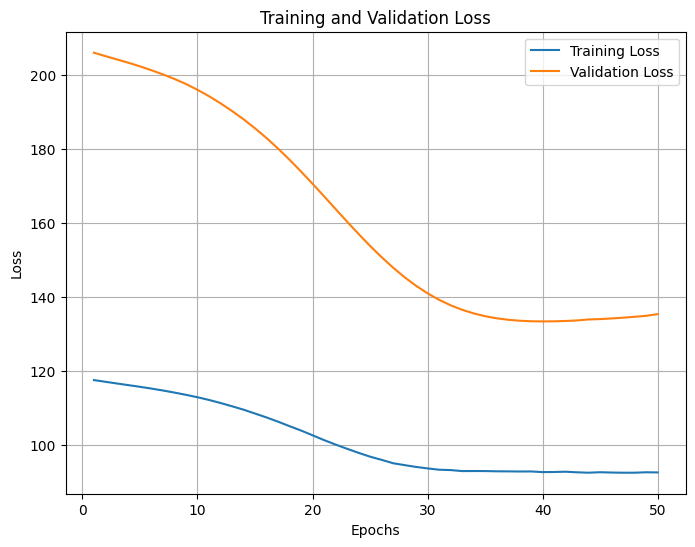

In [25]:
'''
Best trial:
  Value: 133.32041931152344
  Params:
    hidden_size1: 32
    hidden_size2: 256
    hidden_size3: 16
    num_layers: 2
    dropout_rate: 0.2566471654178661
    lr: 0.0005485425809633671
'''

learning_rate = 0.0005485425809633671
num_epochs = 50
input_size = 12
output_size = 1

hidden_size1 = 32
hidden_size2 = 256
hidden_size3 = 16
output_size = 1
num_layers = 2
dropout_rate = 0.2566471654178661

model = WeatherPredictorGRU(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, num_layers, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

def train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for inputs, targets in train_loader:
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  # Plotting
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader)


In [26]:
def evaluate_and_collect_data(model, data_loader, device):
  model.eval()
  total_mae = 0
  count = 0
  predictions = []
  actuals = []

  with torch.no_grad():
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      outputs = model(inputs)
      mae = torch.abs(outputs - targets).mean()
      total_mae += mae.item()
      count += 1

      predictions.extend(outputs.view(-1).detach().cpu().numpy())
      actuals.extend(targets.view(-1).detach().cpu().numpy())


  avg_mae = total_mae / count
  return predictions, actuals, avg_mae

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

predictions, actuals, avg_mae = evaluate_and_collect_data(model, test_loader, device)
print(f'Mean Prediction Error: {avg_mae:.4f}')

Mean Prediction Error: 8.9096


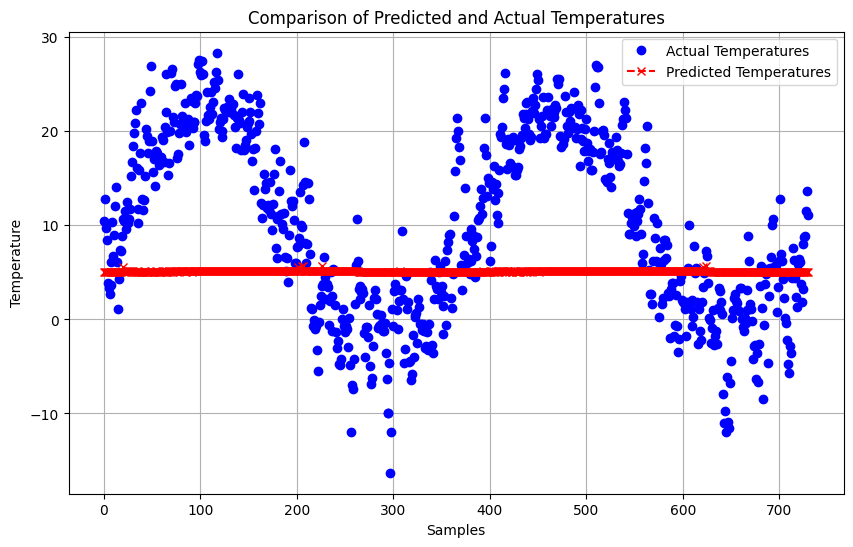

In [27]:
def plot_predictions_vs_actuals(predictions, actuals):
  plt.figure(figsize=(10, 6))
  plt.plot(actuals, label='Actual Temperatures', color='blue', marker='o', linestyle='')
  plt.plot(predictions, label='Predicted Temperatures', color='red', linestyle='--', marker='x')
  plt.title('Comparison of Predicted and Actual Temperatures')
  plt.xlabel('Samples')
  plt.ylabel('Temperature')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_predictions_vs_actuals(predictions, actuals)